# Setup the PEST(++) interface around the enhanced Freyberg model

In [24]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

In [25]:
b_d = os.path.join("..","base_model_files")
nam_file = "freyberg.nam"

### load the model and run once to make sure everything is good-to-go

In [26]:
m = flopy.modflow.Modflow.load(nam_file,model_ws=b_d,check=False,forgive=False)


In [27]:
m.exe_name = "mfnwt"
m.change_model_ws("temp",reset_external=True)
m.write_input()
m.run_model()


changing model workspace...
   temp
FloPy is using the following  executable to run the model: /Users/jeremyw/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/04/24 12:25:46

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/04/24 12:25:46
 Elapsed run time:  0.103 Seconds

  Normal termination of simulation


(True, [])

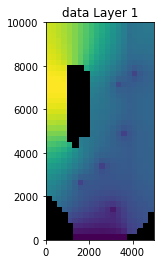

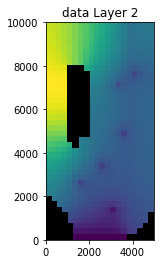

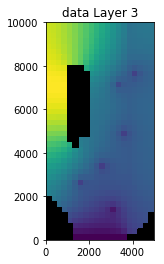

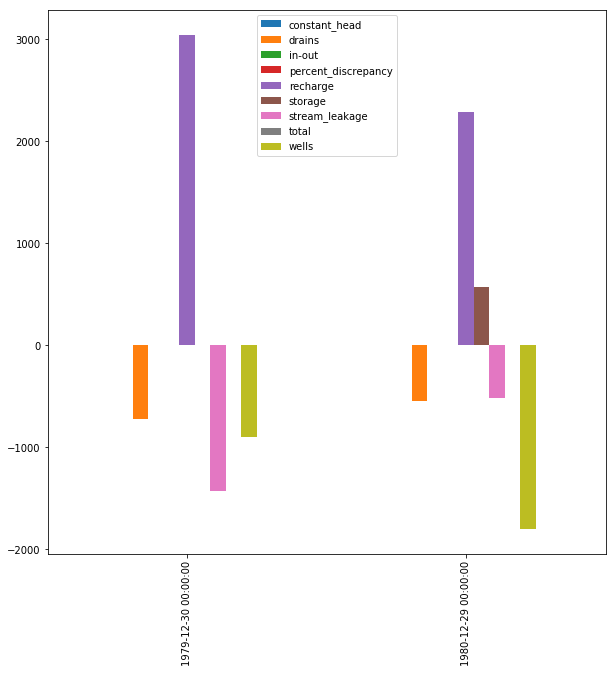

In [28]:
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
hds.plot()
lst = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))
df = lst.get_dataframes(diff=True)[0]
df.plot(kind="bar",figsize=(10,10))

We can see the effect of the "scenario" in the second stress period with less recharge and more abstraction. However, what we are going to do is implement this scenario with parameters so we can more easy account for the stochastic nature of the forcing conditions during the scenario stress period:

FloPy is using the following  executable to run the model: /Users/jeremyw/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/04/24 12:25:46

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/04/24 12:25:47
 Elapsed run time:  0.057 Seconds

  Normal termination of simulation


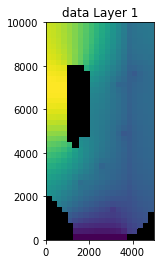

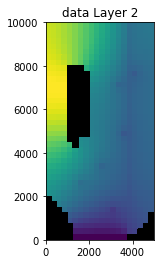

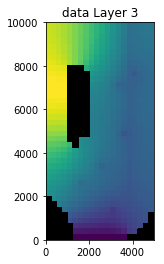

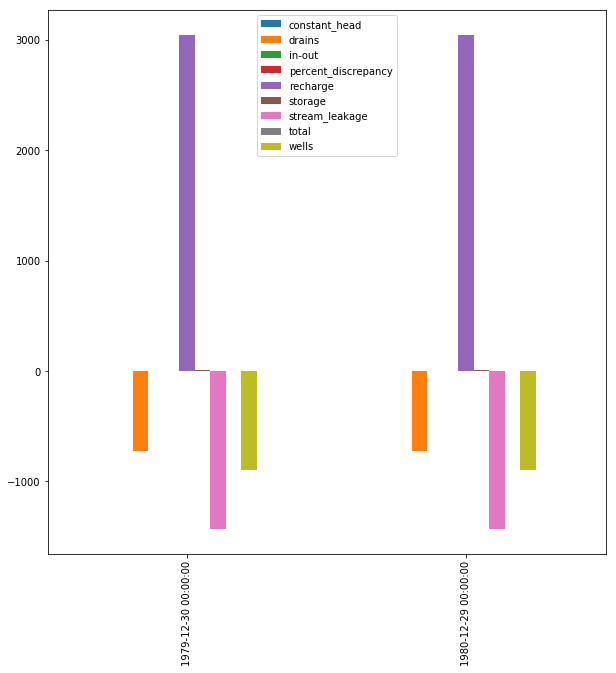

In [29]:
m.rch.rech[1] = m.rch.rech[0]
m.wel.stress_period_data[1] = m.wel.stress_period_data[0]
m.write_input()
m.run_model()
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
hds.plot()
lst = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))
df = lst.get_dataframes(diff=True)[0]
df.plot(kind="bar",figsize=(10,10))

### setup data structures related to what we want to parameterize and what we want to observe

In [30]:
props = []
paks = ["upw.hk","upw.vka","upw.ss","upw.sy"]
for k in range(m.nlay):
    props.extend([[p,k] for p in paks])
props.append(["rch.rech",0])
props.append(["rch.rech",1])


In [31]:
spatial_list_props = [["wel.flux",2],["drn.cond",0]]
temporal_list_props = [["wel.flux",0],["wel.flux",1]]

In [32]:
hds_kperk = [[0,k] for k in range(m.nlay)]
hds_kperk.extend([[1,k] for k in range(m.nlay)])

In [33]:
sfr_obs_dict = {"hw":np.arange(1,21)}
sfr_obs_dict["tw"] = np.arange(20,40)
for i in range(m.nrow):
    sfr_obs_dict[i] = i+1

### here we go...

In [34]:
pst_helper = pyemu.helpers.PstFromFlopyModel(nam_file,new_model_ws="template",org_model_ws="temp",
                                            const_props=props,spatial_list_props=spatial_list_props,
                                             temporal_list_props=temporal_list_props,remove_existing=True,
                                            grid_props=props,pp_props=props,sfr_pars=True,hds_kperk=hds_kperk,
                                             sfr_obs=sfr_obs_dict,build_prior=False,model_exe_name="mfnwt",
                                            pp_space=3)

2019-04-24 12:25:48.085682 starting: loading flopy model

Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> temp/freyberg.nam

--------------------------------------------------
External unit dictionary:
OrderedDict([(2, filename:temp/freyberg.list, filetype:LIST), (11, filename:temp/freyberg.dis, filetype:DIS), (13, filename:temp/freyberg.bas, filetype:BAS6), (31, filename:temp/freyberg.upw, filetype:UPW), (19, filename:temp/freyberg.rch, filetype:RCH), (32, filename:temp/freyberg.nwt, filetype:NWT), (14, filename:temp/freyberg.oc, filetype:OC), (30, filename:temp/freyberg.lmt6, filetype:LMT6), (20, filename:temp/freyberg.wel, filetype:WEL), (17, filename:temp/freyberg.sfr, filetype:SFR), (21, filename:temp/freyberg.drn, filetype:DRN), (50, filename:temp/freyberg.cbc, filetype:DATA(BINARY)), (51, filename:temp/freyberg.hds, filetype:DATA(BINARY)), (60, filename:temp/freyberg.sfr.out, filetype:DATA)])
-------------------

2019-04-24 12:25:50.112022 finished: writing const tpl:ss6.dat_cn.tpl took: 0:00:00.007264
2019-04-24 12:25:50.114787 starting: writing const tpl:sy6.dat_cn.tpl
2019-04-24 12:25:50.122228 finished: writing const tpl:sy6.dat_cn.tpl took: 0:00:00.007441
2019-04-24 12:25:50.124918 starting: writing const tpl:hk7.dat_cn.tpl
2019-04-24 12:25:50.132209 finished: writing const tpl:hk7.dat_cn.tpl took: 0:00:00.007291
2019-04-24 12:25:50.135000 starting: writing const tpl:vka7.dat_cn.tpl
2019-04-24 12:25:50.143089 finished: writing const tpl:vka7.dat_cn.tpl took: 0:00:00.008089
2019-04-24 12:25:50.146080 starting: writing const tpl:ss7.dat_cn.tpl
2019-04-24 12:25:50.152775 finished: writing const tpl:ss7.dat_cn.tpl took: 0:00:00.006695
2019-04-24 12:25:50.155893 starting: writing const tpl:sy7.dat_cn.tpl
2019-04-24 12:25:50.162533 finished: writing const tpl:sy7.dat_cn.tpl took: 0:00:00.006640
2019-04-24 12:25:50.165384 starting: writing const tpl:hk8.dat_cn.tpl
2019-04-24 12:25:50.171947 finis

2019-04-24 12:26:00.455117 forward_run line:pyemu.helpers.apply_array_pars()

all zeros for runoff...skipping...
all zeros for hcond1...skipping...
all zeros for pptsw...skipping...
2019-04-24 12:26:00.600154 starting: processing obs type mflist water budget obs
2019-04-24 12:26:00.726250 forward_run line:pyemu.gw_utils.apply_mflist_budget_obs('freyberg.list',flx_filename='flux.dat',vol_filename='vol.dat',start_datetime='1-1-1970')
2019-04-24 12:26:00.726718 finished: processing obs type mflist water budget obs took: 0:00:00.126564
2019-04-24 12:26:00.726946 starting: processing obs type hyd file
2019-04-24 12:26:00.727239 finished: processing obs type hyd file took: 0:00:00.000293
2019-04-24 12:26:00.727487 starting: processing obs type external obs-sim smp files
2019-04-24 12:26:00.727829 finished: processing obs type external obs-sim smp files took: 0:00:00.000342
2019-04-24 12:26:00.728076 starting: processing obs type hob
2019-04-24 12:26:00.728350 finished: processing obs type ho

The `pst_helper` instance contains the `pyemu.Pst` instance:

In [35]:
pst = pst_helper.pst
pst.npar,pst.nobs

(10881, 4434)

Oh snap!

We need to set some realistic parameter bounds and account for expected (but stochastic) scenario conditions:

In [36]:
par = pst.parameter_data
# properties
tag_dict = {"hk":[0.1,10.0],"vka":[0.1,10]}
for t,[l,u] in tag_dict.items():
    t_pars = par.loc[par.parnme.apply(lambda x: t in x ),"parnme"]
    par.loc[t_pars,"parubnd"] = u
    par.loc[t_pars,"parlbnd"] = l

# recharge - just change the uniform recharge mult
scen_rch = ["rech5_cn"]
hist_rch = ["rech4_cn"]
par.loc[par.pargp.apply(lambda x: x in scen_rch),"parubnd"] = 0.8
par.loc[par.pargp.apply(lambda x: x in scen_rch),"parlbnd"] = 0.1
par.loc[par.pargp.apply(lambda x: x in scen_rch),"parval1"] = 0.4
par.loc[par.pargp.apply(lambda x: x in hist_rch),"parubnd"] = 1.2
par.loc[par.pargp.apply(lambda x: x in hist_rch),"parlbnd"] = 0.8
par.loc[par.pargp.apply(lambda x: x in hist_rch),"parval1"] = 1.0

# well abstraction
par.loc["welflux_001","parval1"] = 1.5
par.loc["welflux_001","parlbnd"] = 1.0
par.loc["welflux_001","parubnd"] = 2.0
par.loc["welflux_000","parval1"] = 1.0
par.loc["welflux_000","parlbnd"] = 0.5
par.loc["welflux_000","parubnd"] = 1.5



In [37]:
pst.write_par_summary_table(filename="none").sort_index()

,type,transform,count,initial value,upper bound,lower bound,standard deviation
drncond_k00,drncond_k00,log,10,0,1,-1,0.5
flow,flow,log,1,0,0.09691,-0.124939,0.0554622
grhk3,grhk3,log,705,0,1,-1,0.5
grhk4,grhk4,log,705,0,1,-1,0.5
grhk5,grhk5,log,705,0,1,-1,0.5
grrech2,grrech2,log,705,0,0.0413927,-0.0457575,0.0217875
grrech3,grrech3,log,705,0,0.0413927,-0.0457575,0.0217875
grss3,grss3,log,705,0,1,-1,0.5
grss4,grss4,log,705,0,1,-1,0.5
grss5,grss5,log,705,0,1,-1,0.5


In [38]:
pst.write_obs_summary_table(filename="none")

,group,value,non-zero weight,zero weight,weight,standard deviation,percent error
flaqx,flaqx,-1013.42 to 32.171,84,0,1,1,0.0986757 to 833.333
flout,flout,10069 to 226396,84,0,1,1,0.000441704 to 0.00993147
flx_constan,flx_constan,0,2,0,1,1,NA
flx_drains,flx_drains,-723.325 to -723.028,2,0,1,1,0.13825 to 0.138307
flx_in-out,flx_in-out,0.012695 to 0.046143,2,0,1,1,2167.18 to 7877.12
flx_percent,flx_percent,0,2,0,1,1,NA
flx_recharg,flx_recharg,3045.6,2,0,1,1,0.0328343
flx_storage,flx_storage,5.7734 to 8.01049,2,0,1,1,12.4836 to 17.3208
flx_stream_,flx_stream_,-1430.27 to -1428.3,2,0,1,1,0.0699167 to 0.0700133
flx_total,flx_total,0.0126953 to 0.0461426,2,0,1,1,2167.2 to 7876.92


Lets run the process once (`noptmax=0`) to make sure its all plumbed up

In [39]:
pst.control_data.noptmax = 0
pst.write(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=pst_helper.new_model_ws)

Now we need to generate stochastic realizations.  We will use the geostatistical covariance information in the `pst_helper` instance for this:

In [40]:
#pst_helper.build_prior()
pe = pst_helper.draw(200)

2019-04-24 12:26:11.828700 starting: drawing realizations
building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:2500.0,anisotropy:1.0,bearing:0.0

working on pargroups ['grhk3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['grvka3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['grss3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['grsy3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['grhk4']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargro

/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['welflux_k02']
build cov matrix
done
getting diag var cov 6
scaling full cov by diag var cov
making full cov draws with home-grown goodness
adding remaining parameters to diagonal
2019-04-24 12:26:17.255776 finished: drawing realizations took: 0:00:05.427076


You can see that parameters are treated in parameter group (`pargp`) blocks for this ensemble generation.  Let's plot one parameter:

Text(0.5, 1.0, 'dc0000390005')

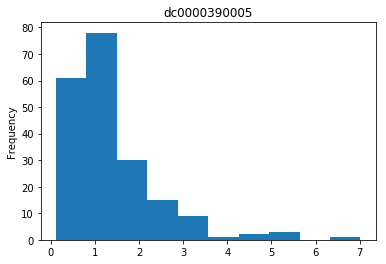

In [41]:
ax = pe.loc[:,pst.par_names[0]].plot(kind="hist")
ax.set_title(pst.par_names[0])

Now we need to enforce parameter bounds and save this ensemble for later

In [42]:
pe.enforce()
pe.to_csv(os.path.join(pst_helper.new_model_ws,"sweep_in.csv"))

### set weights for "observations"

The next major task is to set the weights on the observations.  So far, in the `pst_helper` process, we simply identified what outputs from the model we want to observe.  We now use a pre-cooked csv file to set nonzero weights only for GW level observation locations used in the original Freyberg model.  We will also use the SFR flow out of the last reach (`fo_39_19791230`)

In [43]:
obs_locs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
#build obs names that correspond to the obsnme values in the control file
obs_locs.loc[:,"obsnme"] = obs_locs.apply(lambda x: "hds_00_{0:03d}_{1:03d}_000".format(x.row-1,x.col-1),axis=1)
obs_locs

,row,col,obsnme
0,3,16,hds_00_002_015_000
1,3,10,hds_00_002_009_000
2,4,9,hds_00_003_008_000
3,10,2,hds_00_009_001_000
4,14,11,hds_00_013_010_000
5,16,17,hds_00_015_016_000
6,22,11,hds_00_021_010_000
7,23,16,hds_00_022_015_000
8,25,5,hds_00_024_004_000
9,27,7,hds_00_026_006_000


Set all weights to zero first, then turn on the weights at only a few locations

In [1]:
pst.observation_data.loc[:,"weight"] = 0.0
pst.observation_data.loc[obs_locs.obsnme,"weight"] = 1.0
pst.observation_data.loc[obs_locs.obsnme,"obgnme"] = "calhead"
pst.observation_data.loc["fo_39_19791230","weight"] = 1.0
pst.observation_data.loc["fo_39_19791230","obgnme"] = "calflux"
pst.write(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))
pst.nnz_obs_names

NameError: name 'pst' is not defined

Run one last time.  `phi` should be near zero since we haven't change the `parval1` values for historic stress period and only the 13 gw level obs have nonzero weights

In [45]:
pyemu.os_utils.run("pestpp-ies.exe freyberg.pst",cwd=pst_helper.new_model_ws)
pst = pyemu.Pst(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))
pst.phi

9.456182577320024e-19

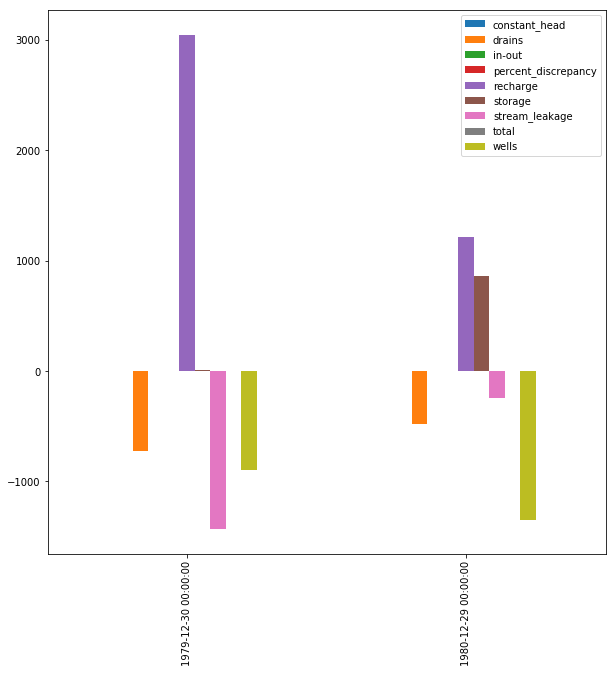

In [46]:
lst = flopy.utils.MfListBudget(os.path.join("template","freyberg.list"))
df = lst.get_dataframes(diff=True)[0]
df.plot(kind="bar",figsize=(10,10))

We see the effect of our parameterized scenario - a large drop in recharge and more abstraction.